In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
from kalman_reconstruction.custom_plot import (
    plot_state_with_probability,
    set_custom_rcParams,
    plot_colors,
    adjust_lightness,
)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from os import PathLike
from pathlib import Path
from typing import Dict
set_custom_rcParams()
# plt.rcParams["figure.figsize"] = (8, 5)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

(<Figure size 500x100 with 1 Axes>, <AxesSubplot: >)

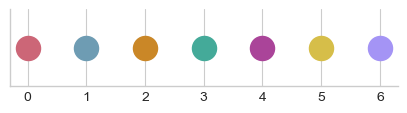

In [2]:
## LIGHT THEME
plt.style.use("seaborn-v0_8-whitegrid")
dark_color = [0.3, 0.3, 0.3]
light_color = [0.8, 0.8, 0.8]
lightness_0 = 0.75
lightness_1 = 0.5
cmap = "rocket"
cmap_r = "rocket_r"

# ### DARK THEME
# plt.style.use("dark_background")
# dark_color = [0.7, 0.7, 0.7]
# light_color = [0.2, 0.2, 0.2]
# lightness_0 = 1.15
# lightness_1 = 1.5
# cmap = "rocket_r"
# cmap_r = "rocket"


colors = set_custom_rcParams()
plt.rcParams["axes.grid"] = True
plot_colors(colors)




In [3]:
REPO_PATH = Path(".").resolve().parent
results_path = REPO_PATH / Path("results") / "Report" / "method_enhancement_10_cycles"
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig : Figure, relative_path : PathLike, kwargs : Dict = dict()):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

### NOTE: make sure dt is correct!

In [4]:
dt = 0.005

In [5]:
names = [
    "0 latent",
    "1 latent",
    "2 latent",
    # "$x = [x_2, x_3, z_1, z_2, z_3]$",
]
name_colors = dict()
name_colors[names[0]] = colors[1]
name_colors[names[1]] = colors[2]
name_colors[names[2]] = colors[4]

experiments = [
    "time_independent",
    "time_dependent",
]

In [6]:
# states = dict(
#     time_dependent = dict(),
#     time_independent = dict(),
# )
# covariances = dict(
#     time_dependent = dict(),
#     time_independent = dict(),
# )
cov_prob = dict(
    time_dependent = dict(),
    time_independent = dict(),
)
rmse = dict(
    time_dependent = dict(),
    time_independent = dict(),
)


repo_path = Path(".").resolve().parent
dir_path = dict(
    time_dependent = repo_path / Path("data/processed/forecast_evaluation_10_cycles/time_dependent"),
    time_independent = repo_path / Path("data/processed/forecast_evaluation_10_cycles/time_independent"),
)

for exp in experiments:
    for key in names :
        save_name = key
        save_name = save_name.replace(" ", "_")
        # # save State
        # save_path = f"state_{save_name}.nc"
        # forecast_test_state[key].to_netcdf(dir_path / save_path)
        # # save Covarinace
        # save_path = f"covariance_{save_name}.nc"
        # forecast_test_covariance[key].to_netcdf(dir_path / save_path)
        # save Coverage probability
        save_path = f"coverage_probability_{save_name}.nc"
        cov_prob[exp][key] = xr.open_dataset(dir_path[exp] / save_path)
        # save RMSE
        save_path = f"rmse_{save_name}.nc"
        rmse[exp][key] = xr.open_dataset(dir_path[exp] / save_path)



In [7]:
cov_prob[exp][key]

<xarray.Dataset>
Dimensions:            (horizon: 100, state_name_copy: 4, kalman_itteration: 30)
Coordinates:
  * horizon            (horizon) int32 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * state_name_copy    (state_name_copy) object 'x2' 'x3' 'z1' 'z2'
  * kalman_itteration  (kalman_itteration) int32 0 1 2 3 4 5 ... 25 26 27 28 29
Data variables:
    x2                 (horizon, state_name_copy) float64 ...
    x3                 (horizon, state_name_copy) float64 ...

### Create perfect forecast and compare to actuall forecast

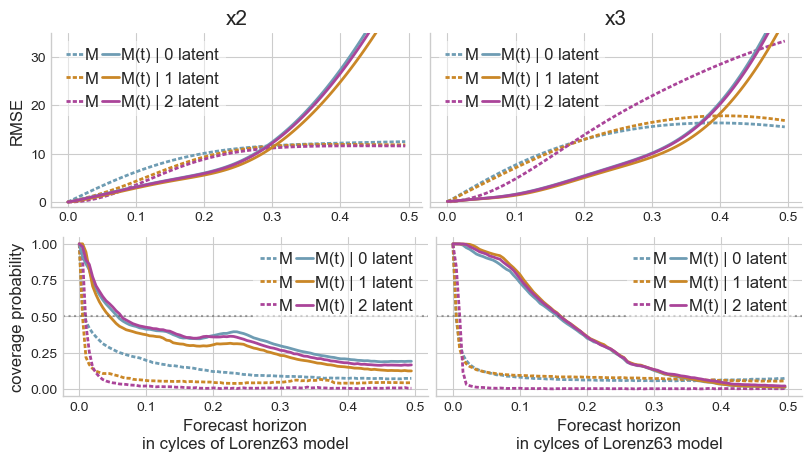

In [8]:
states_to_plot = ["x2", "x3"]
fig = plt.figure(layout = "constrained")
subfigs = fig.subfigures(ncols=1, nrows=2)

axs_rmse = subfigs[0].subplots(ncols=2, nrows=1, sharex=True, sharey=True)
axs_covp = subfigs[1].subplots(ncols=2, nrows=1, sharex=True, sharey=True)


line_kwargs = dict(
    linewidth = 2,
)

exp = experiments[0]
for key in names:
    for idx, var in enumerate(["x2", "x3"]):
        
        # plot rmse:
        axs_rmse[idx].plot(
            rmse[exp][key].horizon *dt, 
            rmse[exp][key][var], 
            label=fr"M",
            color = name_colors[key],
            linestyle = "--",
            dashes=(1.5, 0.75),
            **line_kwargs
        )
        axs_rmse[idx].set_title(var)
        
        # plot cov prob:
        axs_covp[idx].plot(
            cov_prob[exp][key].horizon *dt, 
            cov_prob[exp][key][var].sel(state_name_copy = var),
            label=fr"M",
            color = name_colors[key],
            linestyle = "--",
            dashes=(1.5, 0.75),
            **line_kwargs
        )
        axs_covp[idx].set_xlabel("forecast horizon in cycle of Lorenz63")

exp = experiments[1]
for key in names:
    for idx, var in enumerate(["x2", "x3"]):
        # plot rmse:
        axs_rmse[idx].plot(
            rmse[exp][key].horizon *dt, 
            rmse[exp][key][var], 
            label=fr"M(t) | {key}",
            color = name_colors[key],
            linestyle = "-",
            **line_kwargs
        )
        axs_rmse[idx].set_title(var)
        # plot coverage prob:
        axs_covp[idx].plot(
            cov_prob[exp][key].horizon * dt, 
            cov_prob[exp][key][var].sel(state_name_copy = var),
            label=f"M(t) | {key}",
            color = name_colors[key],
            linestyle = "-",
            **line_kwargs
        )
        axs_covp[idx].set_xlabel("Forecast horizon\nin cylces of Lorenz63 model")
axs_rmse[0].set_ylabel("RMSE")
axs_covp[0].set_ylabel("coverage probability")

for ax in axs_rmse:
    ax.legend(
        ncols=2, 
        loc = "upper left",
        handlelength = 1,
        handletextpad=0.15,
        columnspacing=0.2,
        )
    ax.set_ylim((-1, 35))

for ax in axs_covp:
    ax.axhline(0.5, color=dark_color, alpha=0.5, linestyle=":")
    ax.legend(
        ncols=2, 
        loc = "upper right",
        handlelength = 1,
        handletextpad=0.15,
        columnspacing=0.2,
        )

axs = np.concatenate([axs_covp, axs_rmse])

# for ax in axs:
#     ax.set_xlim(
#         xmin = -0.02,
#         xmax = 0.2,
#         ) 

# Write a function that takes in the dict of dataset
# fig.tight_layout()
save_fig(fig, relative_path="forecast_metrics.pdf")